# **Plant Disease Classification**

---

![alt text](https://cdn-images-1.medium.com/max/1200/1*FswlF4lZPQ4kT_gkybacZw.jpeg)


# Introduction

Getting affected by a disease is very common in plants due to various factors such as fertilizers, cultural practices followed, environmental conditions, etc. These diseases hurt agricultural yield and eventually the economy based on it. 

Any technique or method to overcome this problem and getting a warning before the plants are infected would aid farmers to efficiently cultivate crops or plants, both qualitatively and quantitatively. Thus, disease detection in plants plays a very important role in agriculture.


# Download Dataset


First, we download the `PlantVillage` dataset from Google Drive by using the unique `id` it holds and unzip the downloaded **PlantVillage.zip** into the **PlantVillage** dataset folder.

In [ ]:
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:10, 81.9MB/s]


# Import Libraries


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
Error : [Errno 2] No such file or directory: './PlantVillage/train'

Total number of images: 0


Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

ValueError: ignored

# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 50
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/50
97/97 [==============================] - 79s 466ms/step - loss: 0.7131 - accuracy: 0.0657 - val_loss: 1.3439 - val_accuracy: 0.0423
Epoch 2/50
97/97 [==============================] - 41s 424ms/step - loss: 0.1878 - accuracy: 0.0920 - val_loss: 0.3033 - val_accuracy: 0.0282
Epoch 3/50
97/97 [==============================] - 41s 424ms/step - loss: 0.1365 - accuracy: 0.1815 - val_loss: 0.2535 - val_accuracy: 0.0410
Epoch 4/50
97/97 [==============================] - 41s 424ms/step - loss: 0.1103 - accuracy: 0.2766 - val_loss: 0.1717 - val_accuracy: 0.1231
Epoch 5/50
97/97 [==============================] - 41s 424ms/step - loss: 0.1014 - accuracy: 0.3472 - val_loss: 0.1272 - val_accuracy: 0.2000
Epoch 6/50
97/97 [==============================] - 41s 423ms/step - loss: 0.0847 - accuracy: 0.4676 - val_loss: 0.0866 - val_accuracy: 0.3513
Epoch 7/50
97/97 [==============================] - 41s 424ms/step - loss: 0.0770 - accuracy: 0.5163 - val_loss: 0.

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

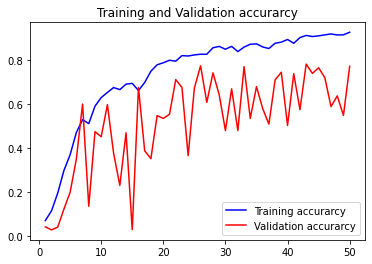

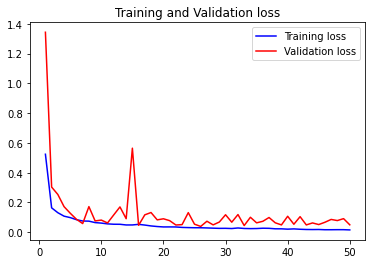

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 1s 32ms/step - loss: 0.0495 - accuracy: 0.7731
Test Accuracy: 77.30769515037537


# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


TypeError: ignored

In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Blueberry___healthy


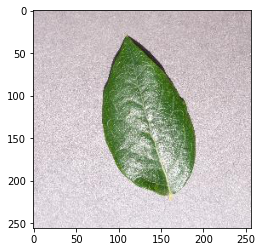

In [ ]:
predict_disease('/content/PlantVillage/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

Potato___Early_blight


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


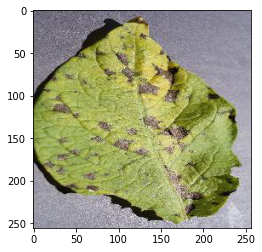

In [ ]:
predict_disease('/content/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

Tomato___Target_Spot


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


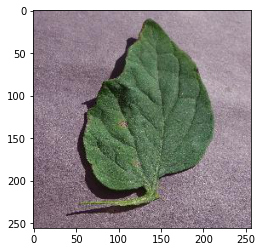

In [ ]:
predict_disease('/content/PlantVillage/val/Tomato___Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')

Orange___Haunglongbing_(Citrus_greening)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


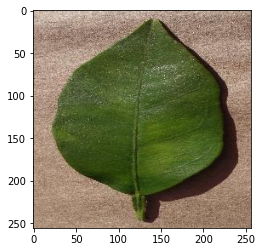

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [ ]:
# Download the trained model file based on its file ID.
file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
!gdown https://drive.google.com/uc?id={file_id}

# Download the labels file based on its file ID.
file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
!gdown https://drive.google.com/uc?id={file_id}

Downloading...
From: https://drive.google.com/uc?id=1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl
To: /content/plant_disease_classification_model.pkl
698MB [00:05, 128MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu
To: /content/plant_disease_label_transform.pkl
100% 8.18k/8.18k [00:00<00:00, 6.91MB/s]


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

Load the trained model and its labels for prediction.

In [ ]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image), axis=-1)
    print((image_labels.classes_[result][0]))

Predict disease of any plant image.

AttributeError: ignored

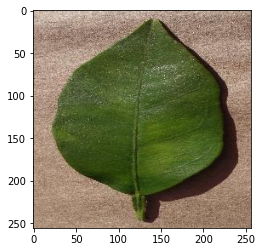

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

#PDC

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [ ]:
logger = keras.callbacks.TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=5
)


# Train the model
model.fit(
    X,
    Y,
    epochs=50,
    shuffle=True,
    verbose=2,
    callbacks=[logger]
)

test_error_rate = model.evaluate(X_test, Y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

# Create a TensorBoard logger
logger = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=5
)

# Train the model
model.fit(
    X,
    Y,
    epochs=50,
    shuffle=True,
    verbose=2,
    callbacks=[logger]
)

# Load the separate test data set
test_data_df = pd.read_csv("sales_data_test_scaled.csv")

X_test = test_data_df.drop('total_earnings', axis=1).values
Y_test = test_data_df[['total_earnings']].values

test_error_rate = model.evaluate(X_test, Y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))